# 🎯 Customer Churn Prediction - Feature Engineering

**Project:** Phase 2 - Machine Learning Churn Model  
**Author:** Rishi Dhandi  
**Date:** January 2026

---

## 📊 Objective

Build features from BrewCraft transaction data to predict customer churn using machine learning.

**Phase 1 Foundation:** [RFM Customer Segmentation](https://github.com/rishi559/RMF-Customer-Segmentation)

**Goals:**
1. Define churn (customers inactive for 90+ days)
2. Engineer behavioral features from transaction history
3. Prepare dataset for K-Means clustering and XGBoost modeling
4. Target: 85-88% prediction accuracy

---

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
%matplotlib inline

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


In [7]:
# Load BrewCraft transaction data
df = pd.read_csv('../data/brewcraft_transactions.csv')

# Convert date column to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

print("="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nDate Range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")
print(f"Total Customers: {df['customer_id'].nunique():,}")
print(f"Total Revenue: ${df['total_amount'].sum():,.2f}")

print("\n--- First 5 Transactions ---")
df.head()

DATA LOADED SUCCESSFULLY
Shape: 133,430 rows × 10 columns

Date Range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Total Customers: 10,000
Total Revenue: $5,842,731.19

--- First 5 Transactions ---


,transaction_id,customer_id,transaction_date,product_name,product_category,quantity,unit_price,total_amount,channel,customer_segment
0,TXN00100000,CUST001000,2023-10-20,Basic Monthly Box,Subscription,1,29.99,29.99,Mobile App,Champions
1,TXN00100001,CUST001000,2023-10-20,Premium Monthly Box,Subscription,1,49.99,49.99,Mobile App,Champions
2,TXN00100002,CUST001000,2023-10-22,Espresso Tamper,Equipment,1,24.99,24.99,Retail Partner,Champions
3,TXN00100003,CUST001000,2023-10-22,Deluxe Monthly Box,Subscription,1,69.99,69.99,Mobile App,Champions
4,TXN00100004,CUST001000,2023-10-25,Basic Monthly Box,Subscription,1,29.99,29.99,Website,Champions


## 🎯 Churn Definition

**Business Rule:** A customer is considered "churned" if they haven't made a purchase in the last **90 days**.

- **Analysis Date:** Last date in our dataset (2023-12-31)
- **Churn Threshold:** 90 days of inactivity
- **Active Customer:** Purchased within last 90 days
- **Churned Customer:** No purchase for 90+ days

In [10]:
# Set analysis date (last date in dataset)
analysis_date = df['transaction_date'].max()
print(f"Analysis Date: {analysis_date}")

# Define churn threshold
CHURN_DAYS = 90
churn_threshold_date = analysis_date - timedelta(days=CHURN_DAYS)

print(f"  Churn Threshold: {churn_threshold_date}")
print(f"  Customers who haven't purchased since {churn_threshold_date} are considered CHURNED")

# Calculate each customer's last purchase date
customer_last_purchase = df.groupby('customer_id')['transaction_date'].max().reset_index()
customer_last_purchase.columns = ['customer_id', 'last_purchase_date']

# Calculate days since last purchase
customer_last_purchase['days_since_last_purchase'] = (analysis_date - customer_last_purchase['last_purchase_date']).dt.days

# Create churn label (1 = churned, 0 = active)
customer_last_purchase['is_churned'] = (customer_last_purchase['days_since_last_purchase'] > CHURN_DAYS).astype(int)

print("\n" + "="*60)
print("CHURN LABELS CREATED")
print("="*60)
print(f"\nTotal Customers: {len(customer_last_purchase):,}")
print(f"Active Customers: {(customer_last_purchase['is_churned'] == 0).sum():,} ({(customer_last_purchase['is_churned'] == 0).sum() / len(customer_last_purchase) * 100:.1f}%)")
print(f"Churned Customers: {(customer_last_purchase['is_churned'] == 1).sum():,} ({(customer_last_purchase['is_churned'] == 1).sum() / len(customer_last_purchase) * 100:.1f}%)")

print("\n--- Sample Data ---")
customer_last_purchase.head(10)

Analysis Date: 2023-12-31 00:00:00
  Churn Threshold: 2023-10-02 00:00:00
  Customers who haven't purchased since 2023-10-02 00:00:00 are considered CHURNED

CHURN LABELS CREATED

Total Customers: 10,000
Active Customers: 5,713 (57.1%)
Churned Customers: 4,287 (42.9%)

--- Sample Data ---


,customer_id,last_purchase_date,days_since_last_purchase,is_churned
0,CUST001000,2023-12-14,17,0
1,CUST001001,2023-12-17,14,0
2,CUST001002,2023-12-13,18,0
3,CUST001003,2023-12-07,24,0
4,CUST001004,2023-12-18,13,0
5,CUST001005,2023-12-18,13,0
6,CUST001006,2023-12-07,24,0
7,CUST001007,2023-12-12,19,0
8,CUST001008,2023-12-19,12,0
9,CUST001009,2023-12-13,18,0


##  Feature Engineering

We'll create features that capture customer behavior patterns:

### **Recency Features:**
- Days since last purchase
- Days since first purchase (customer lifetime)

### **Frequency Features:**
- Total number of transactions
- Average days between purchases
- Purchase frequency trend (recent vs. historical)

### **Monetary Features:**
- Total amount spent
- Average order value
- Spending trend (recent vs. historical)

### **Product Features:**
- Number of unique products purchased
- Favorite product category
- Product diversity score

### **Channel Features:**
- Preferred purchase channel
- Channel diversity

In [11]:
print("="*60)
print("ENGINEERING FEATURES")
print("="*60)

# 1. RECENCY FEATURES
print("\n1️⃣ Calculating Recency Features...")
recency_features = df.groupby('customer_id').agg({
    'transaction_date': ['min', 'max']
}).reset_index()
recency_features.columns = ['customer_id', 'first_purchase_date', 'last_purchase_date']
recency_features['days_since_last_purchase'] = (analysis_date - recency_features['last_purchase_date']).dt.days
recency_features['customer_lifetime_days'] = (recency_features['last_purchase_date'] - recency_features['first_purchase_date']).dt.days

# 2. FREQUENCY FEATURES
print("2️⃣ Calculating Frequency Features...")
frequency_features = df.groupby('customer_id').agg({
    'transaction_id': 'nunique'
}).reset_index()
frequency_features.columns = ['customer_id', 'total_transactions']

# Calculate average days between purchases
customer_transactions = df.groupby('customer_id')['transaction_date'].apply(list).reset_index()
def calc_avg_days_between(dates):
    if len(dates) <= 1:
        return 0
    dates_sorted = sorted(dates)
    gaps = [(dates_sorted[i+1] - dates_sorted[i]).days for i in range(len(dates_sorted)-1)]
    return np.mean(gaps) if gaps else 0

customer_transactions['avg_days_between_purchases'] = customer_transactions['transaction_date'].apply(calc_avg_days_between)
frequency_features = frequency_features.merge(
    customer_transactions[['customer_id', 'avg_days_between_purchases']], 
    on='customer_id'
)

# 3. MONETARY FEATURES
print("3️⃣ Calculating Monetary Features...")
monetary_features = df.groupby('customer_id').agg({
    'total_amount': ['sum', 'mean', 'std']
}).reset_index()
monetary_features.columns = ['customer_id', 'total_spent', 'avg_order_value', 'spending_std']
monetary_features['spending_std'] = monetary_features['spending_std'].fillna(0)

# 4. PRODUCT FEATURES
print("4️⃣ Calculating Product Features...")
product_features = df.groupby('customer_id').agg({
    'product_name': 'nunique',
    'product_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()
product_features.columns = ['customer_id', 'unique_products', 'favorite_category']

# Calculate product diversity (unique products / total transactions)
product_features = product_features.merge(frequency_features[['customer_id', 'total_transactions']], on='customer_id')
product_features['product_diversity'] = product_features['unique_products'] / product_features['total_transactions']
product_features = product_features.drop('total_transactions', axis=1)

# 5. CHANNEL FEATURES
print("5️⃣ Calculating Channel Features...")
channel_features = df.groupby('customer_id').agg({
    'channel': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()
channel_features.columns = ['customer_id', 'preferred_channel']

# Calculate channel diversity
channel_diversity = df.groupby('customer_id')['channel'].nunique().reset_index()
channel_diversity.columns = ['customer_id', 'channel_diversity']
channel_features = channel_features.merge(channel_diversity, on='customer_id')

print("\n✅ All features calculated!")
print(f"   - Recency features: {recency_features.shape[1]-1}")
print(f"   - Frequency features: {frequency_features.shape[1]-1}")
print(f"   - Monetary features: {monetary_features.shape[1]-1}")
print(f"   - Product features: {product_features.shape[1]-1}")
print(f"   - Channel features: {channel_features.shape[1]-1}")

ENGINEERING FEATURES

1️⃣ Calculating Recency Features...
2️⃣ Calculating Frequency Features...
3️⃣ Calculating Monetary Features...
4️⃣ Calculating Product Features...
5️⃣ Calculating Channel Features...

✅ All features calculated!
   - Recency features: 4
   - Frequency features: 2
   - Monetary features: 3
   - Product features: 3
   - Channel features: 2


In [12]:
# Merge all features together
print("="*60)
print("COMBINING ALL FEATURES")
print("="*60)

# Start with recency features
features_df = recency_features.copy()

# Merge frequency features
features_df = features_df.merge(frequency_features, on='customer_id', how='left')

# Merge monetary features
features_df = features_df.merge(monetary_features, on='customer_id', how='left')

# Merge product features
features_df = features_df.merge(product_features, on='customer_id', how='left')

# Merge channel features
features_df = features_df.merge(channel_features, on='customer_id', how='left')

# Add churn label
features_df = features_df.merge(
    customer_last_purchase[['customer_id', 'is_churned']], 
    on='customer_id', 
    how='left'
)

print(f"\n✅ Feature dataset created!")
print(f"Shape: {features_df.shape[0]:,} customers × {features_df.shape[1]} features")

print("\n--- Feature List ---")
print(features_df.columns.tolist())

print("\n--- Sample Data ---")
print(features_df.head(10))

print("\n--- Data Types ---")
print(features_df.dtypes)

COMBINING ALL FEATURES

✅ Feature dataset created!
Shape: 10,000 customers × 16 features

--- Feature List ---
['customer_id', 'first_purchase_date', 'last_purchase_date', 'days_since_last_purchase', 'customer_lifetime_days', 'total_transactions', 'avg_days_between_purchases', 'total_spent', 'avg_order_value', 'spending_std', 'unique_products', 'favorite_category', 'product_diversity', 'preferred_channel', 'channel_diversity', 'is_churned']

--- Sample Data ---
  customer_id first_purchase_date last_purchase_date  \
0  CUST001000          2023-10-20         2023-12-14   
1  CUST001001          2022-08-01         2023-12-17   
2  CUST001002          2022-08-14         2023-12-13   
3  CUST001003          2022-11-24         2023-12-07   
4  CUST001004          2022-05-28         2023-12-18   
5  CUST001005          2023-07-21         2023-12-18   
6  CUST001006          2022-08-31         2023-12-07   
7  CUST001007          2023-05-23         2023-12-12   
8  CUST001008          2023-07

In [14]:
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for missing values
print("\n--- Missing Values ---")
missing = features_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✅ No missing values!")

# Check for duplicates
print(f"\n--- Duplicate Customers ---")
duplicates = features_df['customer_id'].duplicated().sum()
print(f"Duplicates: {duplicates}")
if duplicates == 0:
    print("✅ No duplicates!")

# Summary statistics
print("\n--- Summary Statistics ---")
print(features_df.describe().round(2))

# Check churn distribution
print("\n" + "="*60)
print("CHURN DISTRIBUTION")
print("="*60)
churn_dist = features_df['is_churned'].value_counts()
print(f"\nActive (0): {churn_dist[0]:,} ({churn_dist[0]/len(features_df)*100:.1f}%)")
print(f"Churned (1): {churn_dist[1]:,} ({churn_dist[1]/len(features_df)*100:.1f}%)")

# Check if dataset is imbalanced
churn_ratio = churn_dist[1] / churn_dist[0]
if churn_ratio < 0.3 or churn_ratio > 3:
    print(f"\n⚠️  Imbalanced dataset (ratio: {churn_ratio:.2f})")
    print("   We may need to handle this in modeling phase.")
else:
    print(f"\n✅ Balanced dataset (ratio: {churn_ratio:.2f})")

DATA QUALITY CHECK

--- Missing Values ---
✅ No missing values!

--- Duplicate Customers ---
Duplicates: 0
✅ No duplicates!

--- Summary Statistics ---
              first_purchase_date          last_purchase_date  \
count                       10000                       10000   
mean   2023-01-22 14:57:24.480000  2023-07-24 20:15:56.160000   
min           2021-01-01 00:00:00         2021-01-31 00:00:00   
25%           2022-08-30 00:00:00         2023-04-29 00:00:00   
50%           2023-02-11 00:00:00         2023-10-30 00:00:00   
75%           2023-07-27 00:00:00         2023-12-08 00:00:00   
max           2023-12-31 00:00:00         2023-12-31 00:00:00   
std                           NaN                         NaN   

       days_since_last_purchase  customer_lifetime_days  total_transactions  \
count                  10000.00                10000.00            10000.00   
mean                     159.16                  183.22               13.34   
min                      

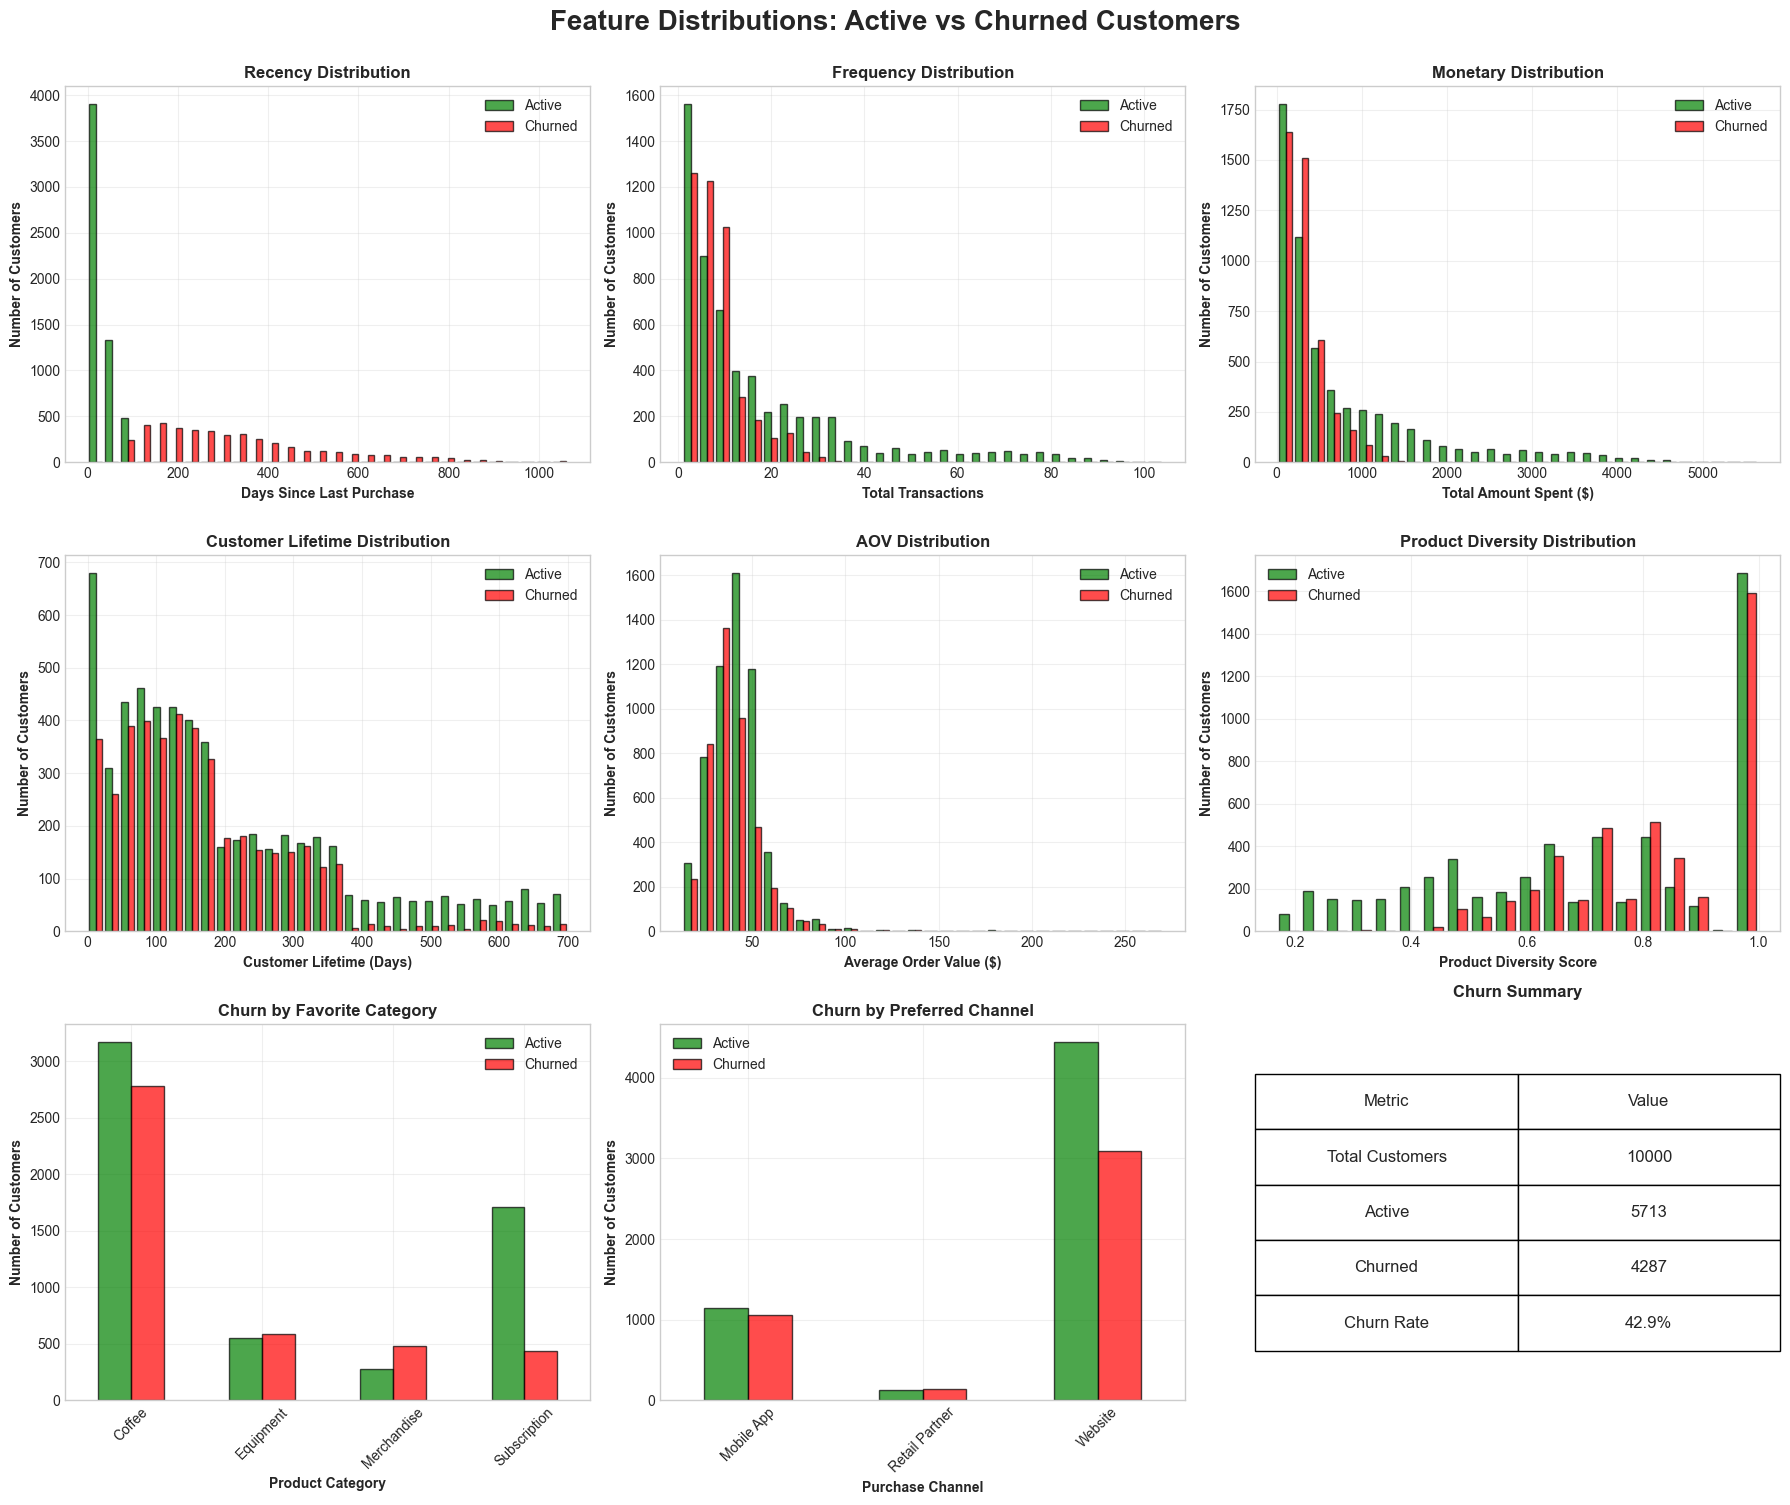

Feature visualizations created!


In [16]:
# Feature distributions and churn patterns
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Feature Distributions: Active vs Churned Customers', fontsize=20, fontweight='bold', y=1.00)

# 1. Days Since Last Purchase
axes[0, 0].hist([features_df[features_df['is_churned']==0]['days_since_last_purchase'],
                 features_df[features_df['is_churned']==1]['days_since_last_purchase']],
                bins=30, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Days Since Last Purchase', fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 0].set_title('Recency Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Total Transactions
axes[0, 1].hist([features_df[features_df['is_churned']==0]['total_transactions'],
                 features_df[features_df['is_churned']==1]['total_transactions']],
                bins=30, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Total Transactions', fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 1].set_title('Frequency Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Total Spent
axes[0, 2].hist([features_df[features_df['is_churned']==0]['total_spent'],
                 features_df[features_df['is_churned']==1]['total_spent']],
                bins=30, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Total Amount Spent ($)', fontweight='bold')
axes[0, 2].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 2].set_title('Monetary Distribution', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Customer Lifetime
axes[1, 0].hist([features_df[features_df['is_churned']==0]['customer_lifetime_days'],
                 features_df[features_df['is_churned']==1]['customer_lifetime_days']],
                bins=30, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Customer Lifetime (Days)', fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[1, 0].set_title('Customer Lifetime Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Average Order Value
axes[1, 1].hist([features_df[features_df['is_churned']==0]['avg_order_value'],
                 features_df[features_df['is_churned']==1]['avg_order_value']],
                bins=30, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Average Order Value ($)', fontweight='bold')
axes[1, 1].set_ylabel('Number of Customers', fontweight='bold')
axes[1, 1].set_title('AOV Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Product Diversity
axes[1, 2].hist([features_df[features_df['is_churned']==0]['product_diversity'],
                 features_df[features_df['is_churned']==1]['product_diversity']],
                bins=20, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Product Diversity Score', fontweight='bold')
axes[1, 2].set_ylabel('Number of Customers', fontweight='bold')
axes[1, 2].set_title('Product Diversity Distribution', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

# 7. Churn by Favorite Category
category_churn = features_df.groupby(['favorite_category', 'is_churned']).size().unstack(fill_value=0)
category_churn.plot(kind='bar', ax=axes[2, 0], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[2, 0].set_xlabel('Product Category', fontweight='bold')
axes[2, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[2, 0].set_title('Churn by Favorite Category', fontweight='bold')
axes[2, 0].legend(['Active', 'Churned'])
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(alpha=0.3)

# 8. Churn by Preferred Channel
channel_churn = features_df.groupby(['preferred_channel', 'is_churned']).size().unstack(fill_value=0)
channel_churn.plot(kind='bar', ax=axes[2, 1], color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[2, 1].set_xlabel('Purchase Channel', fontweight='bold')
axes[2, 1].set_ylabel('Number of Customers', fontweight='bold')
axes[2, 1].set_title('Churn by Preferred Channel', fontweight='bold')
axes[2, 1].legend(['Active', 'Churned'])
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(alpha=0.3)

# 9. Churn Rate Summary
churn_summary = pd.DataFrame({
    'Metric': ['Total Customers', 'Active', 'Churned', 'Churn Rate'],
    'Value': [
        len(features_df),
        (features_df['is_churned']==0).sum(),
        (features_df['is_churned']==1).sum(),
        f"{(features_df['is_churned']==1).sum()/len(features_df)*100:.1f}%"
    ]
})
axes[2, 2].axis('tight')
axes[2, 2].axis('off')
table = axes[2, 2].table(cellText=churn_summary.values, colLabels=churn_summary.columns,
                         cellLoc='center', loc='center', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 3)
axes[2, 2].set_title('Churn Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("Feature visualizations created!")

In [17]:
# Save engineered features to CSV
output_path = '../data/customer_features_engineered.csv'
features_df.to_csv(output_path, index=False)

print("="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

print(f"\n✅ Features saved to: {output_path}")
print(f"\n📊 Final Dataset Summary:")
print(f"   - Total Customers: {len(features_df):,}")
print(f"   - Total Features: {features_df.shape[1]}")
print(f"   - Active Customers: {(features_df['is_churned']==0).sum():,}")
print(f"   - Churned Customers: {(features_df['is_churned']==1).sum():,}")
print(f"   - Churn Rate: {(features_df['is_churned']==1).sum()/len(features_df)*100:.1f}%")

print("\n🎯 Next Steps:")
print("   1. Notebook 2: K-Means Clustering Analysis")
print("   2. Notebook 3: XGBoost Churn Prediction Model")
print("   3. Notebook 4: Business Impact & Recommendations")

print("\n" + "="*60)
print("Ready for Clustering & Machine Learning! 🚀")
print("="*60)

FEATURE ENGINEERING COMPLETE

✅ Features saved to: ../data/customer_features_engineered.csv

📊 Final Dataset Summary:
   - Total Customers: 10,000
   - Total Features: 16
   - Active Customers: 5,713
   - Churned Customers: 4,287
   - Churn Rate: 42.9%

🎯 Next Steps:
   1. Notebook 2: K-Means Clustering Analysis
   2. Notebook 3: XGBoost Churn Prediction Model
   3. Notebook 4: Business Impact & Recommendations

Ready for Clustering & Machine Learning! 🚀
